In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

version_names = {
    'numpy-histo_v0': 'Numpy-Serial',
    'numba-histo_v0': 'Numba+Numpy-Serial',
    'numba-histo_v1': 'Numba-Unroll-Serial',
    'numba-histo_v2': 'Numba-Semi-Parallel',
    # 'numba-histo_v3': 'Numba-v3',
    # 'numba-histo_v4': 'Numba-v4',
    'numba-histo_v5': 'Numba-Fully-Parallel',
    'cpp-histo': 'C++-Fully-Parallel',
    # 'cpp-histo_v2': 'C++-v2',
    # 'cpp-histo_v3': 'C++-v3',
    # 'cpp-histo_v4': 'C++-v4',
    # 'cpp-histo_v5': 'C++-v5',
}

colors = {
    'cpp-histo': 'tab:blue',
    'cpp-histo_v2': 'tab:olive',
    'numba-histo_v0': 'tab:orange',
    'numba-histo_v1': 'tab:green',
    'numba-histo_v2': 'tab:red',
    'numba-histo_v5': 'tab:purple',
    'numpy-histo_v0': 'tab:brown'
}


In [2]:
data_file = 'results-2023-09-13.csv'

df = pd.read_csv(data_file, sep='\t', header=0)
df = df.drop(columns=['n_rf'])
print(df.shape)
print(df.head())

# remove rows with suite == 'numba_par', benchmar == 'histo' or 'histo_v1' and n_thr > 1
df = df[~((df['suite'] == 'numba_par') & (df['benchmark'].isin(['histo', 'histo_v1'])) & (df['n_thr'] > 1))]
print(df.shape)

# drop numba histo_v3, histo_v4
df = df[~((df['suite'] == 'numba') & (df['benchmark'].isin(['histo_v3', 'histo_v4'])))]

# drop numba histo_v0, histo_v1 for threads> 1
df = df[~((df['suite'] == 'numba') & (df['benchmark'].isin(['histo_v0', 'histo_v1'])) & (df['n_thr'] > 1))]

# drop cpp histo_v3, histo_v4, histo_v5
df = df[~((df['suite'] == 'cpp') & (df['benchmark'].isin(['histo_v3', 'histo_v4', 'histo_v5'])))]

mean_df = df.groupby(['suite', 'benchmark', 'particles', 'slices', 'n_thr']).mean()
print(mean_df.head())


(861, 9)
   suite benchmark  avg(ms)    std     min      max  particles  slices  n_thr
0  numpy  histo_v0    9.302  1.044   8.398   12.995    1000000     128      1
1  numpy  histo_v0   22.712  2.310  17.140   30.488    2000000     256      1
2  numpy  histo_v0   38.267  4.258  33.378   46.683    4000000     512      1
3  numpy  histo_v0   76.688  8.142  69.659  100.919    8000000    1024      1
4  numpy  histo_v0    8.690  0.257   8.398    9.973    1000000     128      1
(861, 9)
                                         avg(ms)       std       min     max
suite benchmark particles slices n_thr                                      
cpp   histo     1000000   128    1      2.232700  0.110800  2.000200  2.7055
                                 2      1.194800  0.092400  1.088100  1.6309
                                 4      0.744000  0.190300  0.633600  2.0519
                                 8      0.543063  0.214938  0.436063  2.0650
                2000000   256    1      5.168800  0.

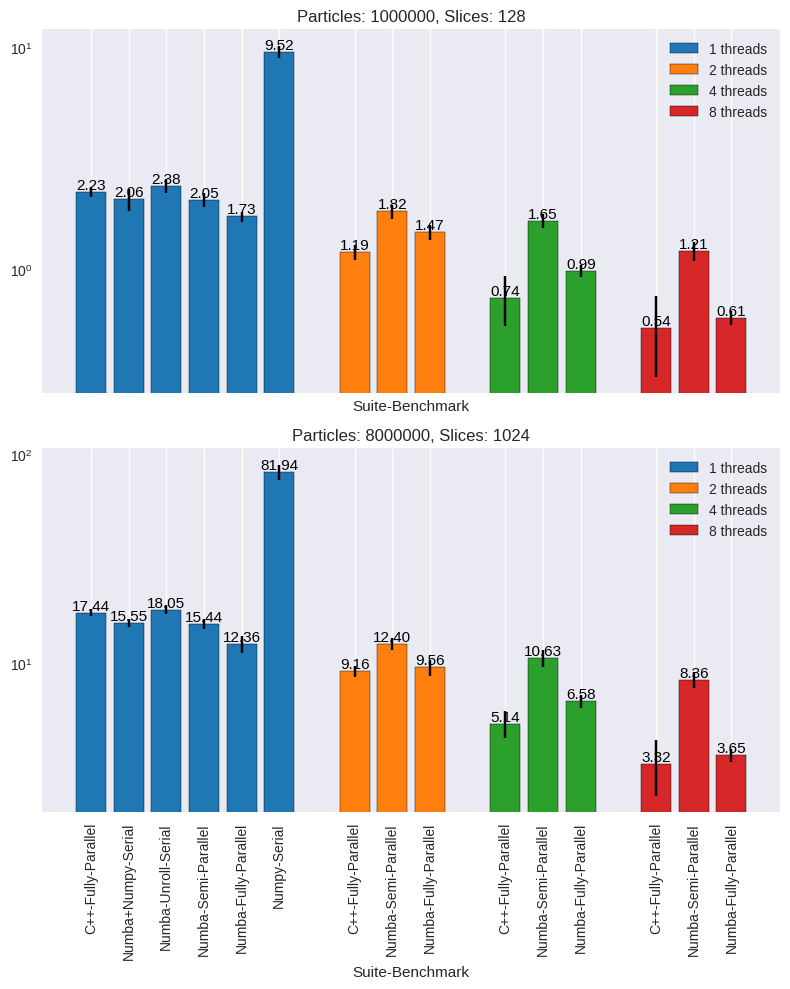

In [3]:
particles_lst = mean_df.index.unique(level='particles').to_list()
slices_lst = mean_df.index.unique(level='slices').to_list()
n_thr_lst = mean_df.index.unique(level='n_thr').to_list()

n_particles = particles_lst[0]
n_slices = slices_lst[0]
# n_thr = n_thr_lst[0]

colors_threads = {
    1: 'tab:blue',
    2: 'tab:orange',
    4: 'tab:green',
    8: 'tab:red',
}

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), sharex=True, sharey=False)

for n_particles, n_slices, ax in zip([1000000, 8000000], [128, 1024], axes.flat):
    plt.sca(ax)

    offset = 0
    xticks = []
    xlabels = []
    for n_thr in n_thr_lst:

        temp_df = mean_df.loc[(mean_df.index.get_level_values('particles') == n_particles) &
                       (mean_df.index.get_level_values('slices') == n_slices) &
                       (mean_df.index.get_level_values('n_thr') == n_thr)]
        suite = temp_df.index.get_level_values('suite').to_list()
        benchmark = temp_df.index.get_level_values('benchmark').to_list()
        if (suite == 'numba' and benchmark in ['histo_v3', 'histo_v4']):
            continue
        
        thread = temp_df.index.get_level_values('n_thr').to_list()
        key = f'{suite}-{benchmark}'

        n_vals = len(temp_df)
        y = temp_df['avg(ms)']
        yerr = temp_df['std']
        ymin = temp_df['min']
        ymax = temp_df['max']
        x = np.arange(offset, offset + n_vals).tolist()
        xlabels += [version_names[f'{s}-{b}'] for s, b, in zip(suite, benchmark)]
        xticks += x
        # create barplot with errors
        plt.bar(x, y, width=0.8, yerr=[np.minimum(yerr, y)], 
                color=colors_threads[int(n_thr)], edgecolor='black', 
                label=f'{n_thr} threads')
        # annotate all bars with ax.annotate
        for i, v in enumerate(y):
            plt.annotate(f'{v:.2f}', xy=(x[i], v), ha='center',
                            va='bottom', fontsize=11, color='black')
            # plt.text(x[i]-0.2, v-1, f'{v:.2f}', fontsize=10,
            #          color='black', rotation=90)


        offset += n_vals+1

    xlabels = [i.replace('-histo', '').replace('_par', '') for i in xlabels]

    # enable y grid lines
    ax.set_yscale('log')
    plt.title(f'Particles: {n_particles}, Slices: {n_slices}')
    plt.xlabel('Suite-Benchmark')
    plt.grid(axis='y')
    plt.xticks(xticks, xlabels, rotation=90)
    plt.legend()
    plt.tight_layout()

# fig.delaxes(axes[2, 1])

plt.savefig('dse-parts-threads-suites-bars.png', bbox_inches='tight')
plt.show()




[('numpy', 'histo_v0'), ('numba', 'histo_v0'), ('numba', 'histo_v1'), ('numba', 'histo_v2'), ('numba', 'histo_v5'), ('cpp', 'histo')]


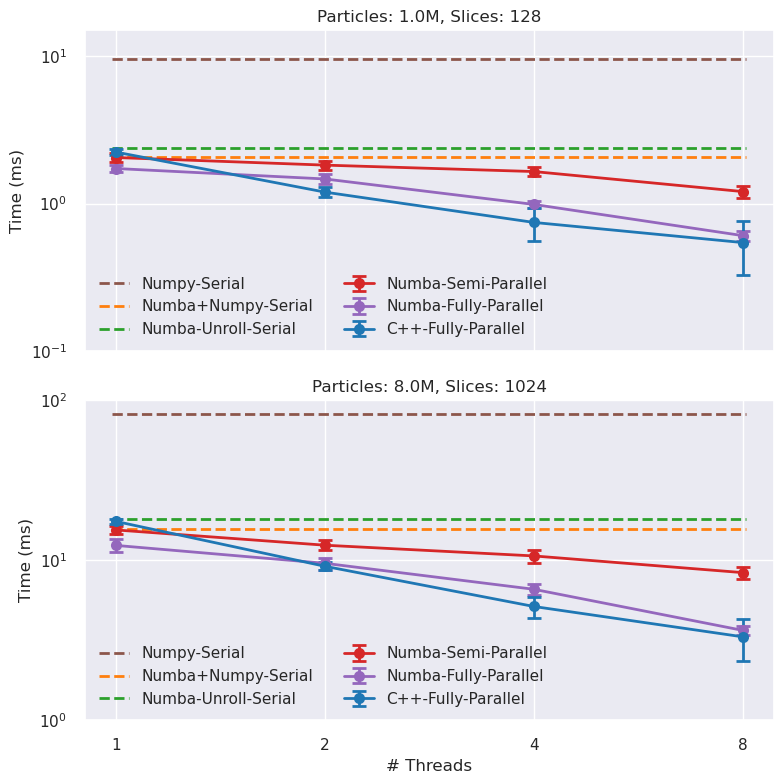

In [14]:
# make the plots interactive

particles_lst = mean_df.index.unique(level='particles').to_list()
slices_lst = mean_df.index.unique(level='slices').to_list()

# suite_benchmark_lst = np.unique(np.array(mean_df.index.unique().tolist())[:, :2],axis=0)
suite_benchmark_lst = list(version_names.keys())
suite_benchmark_lst = [(i.split('-')[0], i.split('-')[1]) for i in suite_benchmark_lst]

print(suite_benchmark_lst)


sns.set_theme()
# plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True, sharey=False)

for n_particles, n_slices, ax in zip([1000000, 8000000], [128, 1024], axes.flat):
    plt.sca(ax)

    offset = 0
    xticks = []
    xlabels = []
    
    # df.plot.line(y='avg(ms)', ax=ax, legend=True)
    for suite_benchmark in suite_benchmark_lst:
        suite = suite_benchmark[0]
        benchmark = suite_benchmark[1]

        temp_df = mean_df.loc[(mean_df.index.get_level_values('particles') == n_particles) &
                       (mean_df.index.get_level_values('slices') == n_slices) &
                       (mean_df.index.get_level_values('suite') == suite) &
                       (mean_df.index.get_level_values('benchmark') == benchmark)]
        
        n_vals = len(temp_df)
        y = temp_df['avg(ms)']
        x = np.arange(n_vals).tolist()
        yerr = temp_df['std']
        key = f'{suite}-{benchmark}'
        if n_vals == 1:
            plt.axhline(y[0], xmin=0.04, xmax=0.96, ls='--', lw=2, color=colors[key], label=version_names[key])
        else:
            plt.errorbar(x, y, yerr=np.minimum(yerr, y), marker='o', label=version_names[key],
                        lw=2, markersize=8, capsize=5, capthick=2, color=colors[key])

    # enable y grid lines
    ax.set_yscale('log')
    plt.title(f'Particles: {n_particles//1e6}M, Slices: {n_slices}')
    if (n_particles == 1000000):
        plt.ylim(0.1, 15)
    elif (n_particles == 8000000):
        plt.ylim(1, 100)
    if ax == axes[-1]:
        plt.xlabel('# Threads')
    plt.ylabel('Time (ms)')
    plt.xticks([0, 1, 2, 3], [1, 2, 4, 8])
    plt.legend(ncol=2)
    plt.tight_layout()

plt.savefig('dse-parts-threads-suites-lines.png', dpi=300, bbox_inches='tight')
plt.show()